Timeseries Classification: KNN & DTW
===
Mark Regan

---
When it comes to building a classification algorithm, analysts have a broad range of open source options to choose from. However, for time series classification, there are less out-of-the box solutions. Many of the typical classification algorithms (Logistic Regression, Random Forests, SVM etc) are applicable to time-series data when the temporal data structure is abstracted away through feature engineering.

My experience with this approach has been poor. The full timeseries feature vector contains a large amount of valuable information that can be lost through the process of flattening the datastructure.

I began researching the domain of time series classification and was intrigued by a recommended technique called K Nearest Neighbors and Dynamic Time Warping. A meta analysis completed by Mitsa (2010) suggests that when it comes to timeseries classification, 1 Nearest Neighbor (K=1) and Dynamic Timewarping is very difficult to beat [1].

##K Nearest Neighbors & Dynamic Time Warping

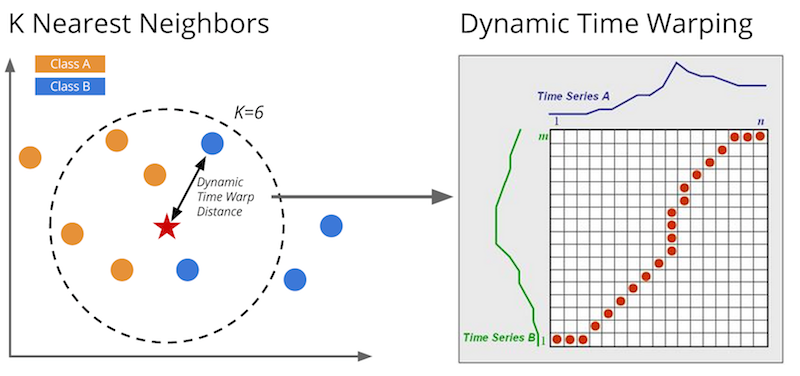

In [1]:
from IPython.display import Image
Image('images/dtw_knn_schematic.png', width=780)

K Nearest Neighbors is a classification algorithm familiar to many. It takes a unlabled observation (the star above) and compares it to a population of labled observations (blue and orange circles). By finding the K nearest circles to the star, we can infer the class label for the star through majority voting.

We can also use KNN in the context of time series data. The question becomes, "how do we compute the distance between two timeseries sequences"? "Dynamic Time Warping" is a technique that was heavily used for speech recognition in the 80s. The DTW algorithm finds the optimum alignment between two sequences of observations by warping the time dimension with certain constraints.

Because of this temporal dimension warping, DTW is good for classifying sequences that have different frequences or that are out of phase. Later we'll see how we can use DTW to classify whether a person is walking, lying down, sitting etc.

The above right diagram shows how a DTW distance matrix representation. Each cell is computed by measuring the distance between $A_i$ and $B_j$. The red path represents the shortest path and hence optimum alignment of the two sequences. 

$$DTW_{AB} = SUM(shortest\ paths_{AB})$$

####Max Warping Window Allowed
Computing the full distance matrix between A and B scales with $O(n^2)$, where n is the number of sequences in A and B. This performance can be improved by constraining the amount of warping allowed. This limits the number of cells that need to be computed in the DTW distance matrix. Research by Keogh et al has shown that a warping window not only improves performance but also improves classification accuracy [2].

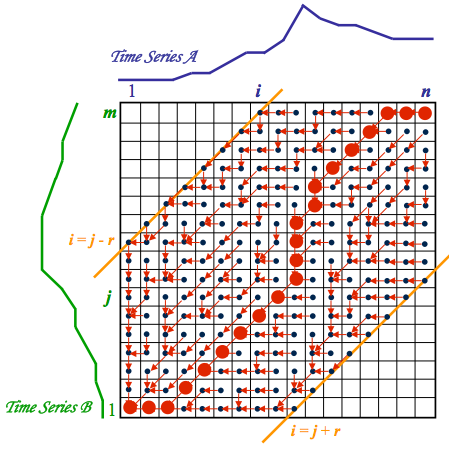

In [2]:
Image('images/max_window_warping.png')

####Coded in Python
The below python code represents the KNN & DTW classification algorithm. The following key methods are described:

| Method        | Description                                                                                                           |
|---------------|-----------------------------------------------------------------------------------------------------------------------|
| `_dtw_distance` | computes the Dynamic Time Warping distance between two sequences                                                      |
| `_dist_matrix`  | computes the distance matrix between $A$ and $B$                  |
| `predict`       | uses both of the above methods to compute the class labels and probability of dataset $B$ through K Nearest Neighbors |

In [7]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print ('\r', self,)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

#### Measuring the DTW distance
The DTW distance between two sequences can be calculated using the `_dtw_distance()` method

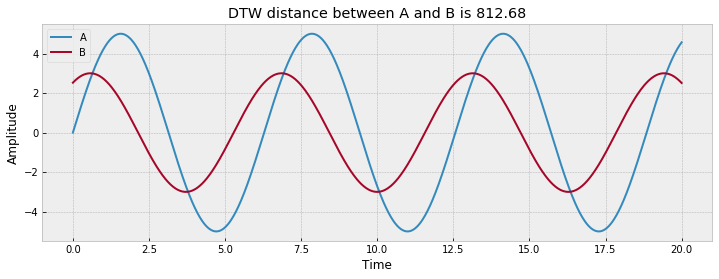

In [8]:
time = np.linspace(0,20,1000)
amplitude_a = 5*np.sin(time)
amplitude_b = 3*np.sin(time + 1)

m = KnnDtw()
distance = m._dtw_distance(amplitude_a, amplitude_b)

fig = plt.figure(figsize=(12,4))
_ = plt.plot(time, amplitude_a, label='A')
_ = plt.plot(time, amplitude_b, label='B')
_ = plt.title('DTW distance between A and B is %.2f' % distance)
_ = plt.ylabel('Amplitude')
_ = plt.xlabel('Time')
_ = plt.legend()

It is also possible to compute the distance between each pair of two collections of inputs by using the `_dist_matrix()` method. These are the two methods which underpin the KnnDtw() classification algorithm. In the next section we will use the `fit()` and `predict()` method to train our classifier and predict class labels forunseen data.

In [5]:
m._dist_matrix(np.random.random((4,50)), np.random.random((4,50)))

[****************100%******************]  16 of 16 complete

array([[  8.23266932,  10.69306752,   8.64633783,   9.32063527],
       [  8.10594233,   8.28282499,   8.32599861,  10.05961871],
       [  7.85953015,   8.71231086,   9.12059861,   8.74224623],
       [ 10.10324773,  10.13287959,   8.98606925,  11.63278765]])

## Human Activity Recognition Dataset
The Human Activity Recognition Dataset (HAR) dataset is chosen to test the classification performance of DTW & KNN [3].

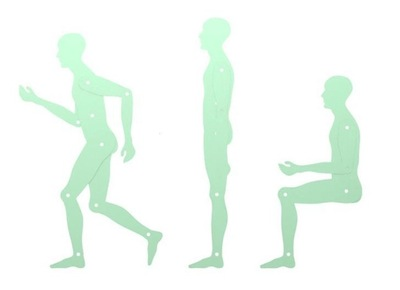

In [6]:
Image('images/stand-sit-run.jpg')

> The experiments were carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (walking, walking upstairs, walking downstairs, sitting, standing and laying) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually.

The remainder of this analysis uses a training and test dataset provided by the authors. They have combined the above timeseries signals and created a single timeseries feature vector. Unfortunately, their methodology is not described.

####Import the HAR dataset

In [9]:
# Import the HAR dataset
x_train_file = open('data/UCI-HAR-Dataset/train/X_train.txt', 'r')
y_train_file = open('data/UCI-HAR-Dataset/train/y_train.txt', 'r')

x_test_file = open('data/UCI-HAR-Dataset/test/X_test.txt', 'r')
y_test_file = open('data/UCI-HAR-Dataset/test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

#### Visualizing sample observations from the HAR dataset

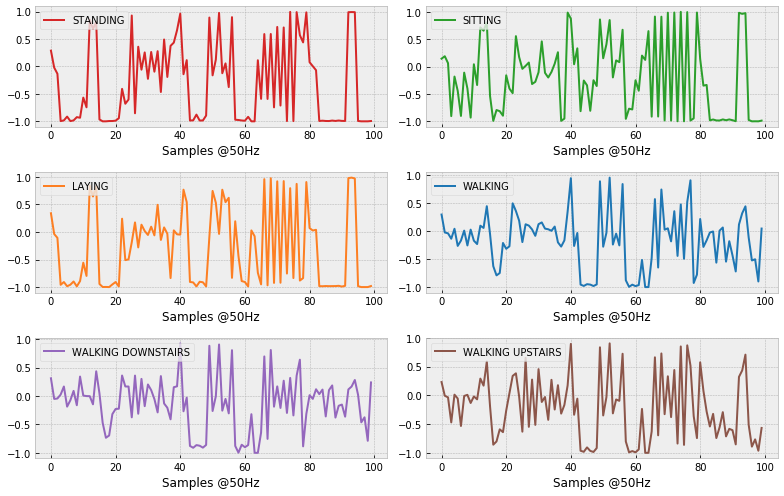

In [10]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

for i, r in enumerate([0,27,65,100,145,172]):
    plt.subplot(3,2,i+1)
    plt.plot(x_train[r][:100], label=labels[y_train[r]], color=colors[i], linewidth=2)
    plt.xlabel('Samples @50Hz')
    plt.legend(loc='upper left')
    plt.tight_layout()

In [16]:
y_train

array([5, 5, 5, ..., 2, 2, 2])

#### Model Performance
The performance of the KNN & DTW classifier is measured by comparing the class labels from the holdout dataset against predictions made by the classifier. The HAR dataset was pre-split into 70% training and 30% test. Cross validation was not performed.

In [11]:
m = KnnDtw(n_neighbors=1, max_warping_window=10)
m.fit(x_train[::10], y_train[::10])
label, proba = m.predict(x_test[::10])

 [                  0%                  ]
 [                  0%                  ]  2 of 217120 complete
 [                  0%                  ]  3 of 217120 complete
 [                  0%                  ]  4 of 217120 complete
 [                  0%                  ]  5 of 217120 complete
 [                  0%                  ]  6 of 217120 complete
 [                  0%                  ]  7 of 217120 complete
 [                  0%                  ]  8 of 217120 complete
 [                  0%                  ]  9 of 217120 complete
 [                  0%                  ]  10 of 217120 complete
 [                  0%                  ]  11 of 217120 complete
 [                  0%                  ]  12 of 217120 complete
 [                  0%                  ]  13 of 217120 complete
 [                  0%                  ]  14 of 217120 complete
 [                  0%                  ]  15 of 217120 complete
 [                  0%                  ]  16 of 217120 

 [                  0%                  ]  128 of 217120 complete
 [                  0%                  ]  129 of 217120 complete
 [                  0%                  ]  130 of 217120 complete
 [                  0%                  ]  131 of 217120 complete
 [                  0%                  ]  132 of 217120 complete
 [                  0%                  ]  133 of 217120 complete
 [                  0%                  ]  134 of 217120 complete
 [                  0%                  ]  135 of 217120 complete
 [                  0%                  ]  136 of 217120 complete
 [                  0%                  ]  137 of 217120 complete
 [                  0%                  ]  138 of 217120 complete
 [                  0%                  ]  139 of 217120 complete
 [                  0%                  ]  140 of 217120 complete
 [                  0%                  ]  141 of 217120 complete
 [                  0%                  ]  142 of 217120 complete
 [        

 [                  0%                  ]  253 of 217120 complete
 [                  0%                  ]  254 of 217120 complete
 [                  0%                  ]  255 of 217120 complete
 [                  0%                  ]  256 of 217120 complete
 [                  0%                  ]  257 of 217120 complete
 [                  0%                  ]  258 of 217120 complete
 [                  0%                  ]  259 of 217120 complete
 [                  0%                  ]  260 of 217120 complete
 [                  0%                  ]  261 of 217120 complete
 [                  0%                  ]  262 of 217120 complete
 [                  0%                  ]  263 of 217120 complete
 [                  0%                  ]  264 of 217120 complete
 [                  0%                  ]  265 of 217120 complete
 [                  0%                  ]  266 of 217120 complete
 [                  0%                  ]  267 of 217120 complete
 [        

 [                  0%                  ]  378 of 217120 complete
 [                  0%                  ]  379 of 217120 complete
 [                  0%                  ]  380 of 217120 complete
 [                  0%                  ]  381 of 217120 complete
 [                  0%                  ]  382 of 217120 complete
 [                  0%                  ]  383 of 217120 complete
 [                  0%                  ]  384 of 217120 complete
 [                  0%                  ]  385 of 217120 complete
 [                  0%                  ]  386 of 217120 complete
 [                  0%                  ]  387 of 217120 complete
 [                  0%                  ]  388 of 217120 complete
 [                  0%                  ]  389 of 217120 complete
 [                  0%                  ]  390 of 217120 complete
 [                  0%                  ]  391 of 217120 complete
 [                  0%                  ]  392 of 217120 complete
 [        

 [                  0%                  ]  503 of 217120 complete
 [                  0%                  ]  504 of 217120 complete
 [                  0%                  ]  505 of 217120 complete
 [                  0%                  ]  506 of 217120 complete
 [                  0%                  ]  507 of 217120 complete
 [                  0%                  ]  508 of 217120 complete
 [                  0%                  ]  509 of 217120 complete
 [                  0%                  ]  510 of 217120 complete
 [                  0%                  ]  511 of 217120 complete
 [                  0%                  ]  512 of 217120 complete
 [                  0%                  ]  513 of 217120 complete
 [                  0%                  ]  514 of 217120 complete
 [                  0%                  ]  515 of 217120 complete
 [                  0%                  ]  516 of 217120 complete
 [                  0%                  ]  517 of 217120 complete
 [        

 [                  0%                  ]  628 of 217120 complete
 [                  0%                  ]  629 of 217120 complete
 [                  0%                  ]  630 of 217120 complete
 [                  0%                  ]  631 of 217120 complete
 [                  0%                  ]  632 of 217120 complete
 [                  0%                  ]  633 of 217120 complete
 [                  0%                  ]  634 of 217120 complete
 [                  0%                  ]  635 of 217120 complete
 [                  0%                  ]  636 of 217120 complete
 [                  0%                  ]  637 of 217120 complete
 [                  0%                  ]  638 of 217120 complete
 [                  0%                  ]  639 of 217120 complete
 [                  0%                  ]  640 of 217120 complete
 [                  0%                  ]  641 of 217120 complete
 [                  0%                  ]  642 of 217120 complete
 [        

 [                  0%                  ]  753 of 217120 complete
 [                  0%                  ]  754 of 217120 complete
 [                  0%                  ]  755 of 217120 complete
 [                  0%                  ]  756 of 217120 complete
 [                  0%                  ]  757 of 217120 complete
 [                  0%                  ]  758 of 217120 complete
 [                  0%                  ]  759 of 217120 complete
 [                  0%                  ]  760 of 217120 complete
 [                  0%                  ]  761 of 217120 complete
 [                  0%                  ]  762 of 217120 complete
 [                  0%                  ]  763 of 217120 complete
 [                  0%                  ]  764 of 217120 complete
 [                  0%                  ]  765 of 217120 complete
 [                  0%                  ]  766 of 217120 complete
 [                  0%                  ]  767 of 217120 complete
 [        

 [                  0%                  ]  878 of 217120 complete
 [                  0%                  ]  879 of 217120 complete
 [                  0%                  ]  880 of 217120 complete
 [                  0%                  ]  881 of 217120 complete
 [                  0%                  ]  882 of 217120 complete
 [                  0%                  ]  883 of 217120 complete
 [                  0%                  ]  884 of 217120 complete
 [                  0%                  ]  885 of 217120 complete
 [                  0%                  ]  886 of 217120 complete
 [                  0%                  ]  887 of 217120 complete
 [                  0%                  ]  888 of 217120 complete
 [                  0%                  ]  889 of 217120 complete
 [                  0%                  ]  890 of 217120 complete
 [                  0%                  ]  891 of 217120 complete
 [                  0%                  ]  892 of 217120 complete
 [        

 [                  0%                  ]  1003 of 217120 complete
 [                  0%                  ]  1004 of 217120 complete
 [                  0%                  ]  1005 of 217120 complete
 [                  0%                  ]  1006 of 217120 complete
 [                  0%                  ]  1007 of 217120 complete
 [                  0%                  ]  1008 of 217120 complete
 [                  0%                  ]  1009 of 217120 complete
 [                  0%                  ]  1010 of 217120 complete
 [                  0%                  ]  1011 of 217120 complete
 [                  0%                  ]  1012 of 217120 complete
 [                  0%                  ]  1013 of 217120 complete
 [                  0%                  ]  1014 of 217120 complete
 [                  0%                  ]  1015 of 217120 complete
 [                  0%                  ]  1016 of 217120 complete
 [                  0%                  ]  1017 of 217120 comp

 [                  1%                  ]  1126 of 217120 complete
 [                  1%                  ]  1127 of 217120 complete
 [                  1%                  ]  1128 of 217120 complete
 [                  1%                  ]  1129 of 217120 complete
 [                  1%                  ]  1130 of 217120 complete
 [                  1%                  ]  1131 of 217120 complete
 [                  1%                  ]  1132 of 217120 complete
 [                  1%                  ]  1133 of 217120 complete
 [                  1%                  ]  1134 of 217120 complete
 [                  1%                  ]  1135 of 217120 complete
 [                  1%                  ]  1136 of 217120 complete
 [                  1%                  ]  1137 of 217120 complete
 [                  1%                  ]  1138 of 217120 complete
 [                  1%                  ]  1139 of 217120 complete
 [                  1%                  ]  1140 of 217120 comp

 [                  1%                  ]  1249 of 217120 complete
 [                  1%                  ]  1250 of 217120 complete
 [                  1%                  ]  1251 of 217120 complete
 [                  1%                  ]  1252 of 217120 complete
 [                  1%                  ]  1253 of 217120 complete
 [                  1%                  ]  1254 of 217120 complete
 [                  1%                  ]  1255 of 217120 complete
 [                  1%                  ]  1256 of 217120 complete
 [                  1%                  ]  1257 of 217120 complete
 [                  1%                  ]  1258 of 217120 complete
 [                  1%                  ]  1259 of 217120 complete
 [                  1%                  ]  1260 of 217120 complete
 [                  1%                  ]  1261 of 217120 complete
 [                  1%                  ]  1262 of 217120 complete
 [                  1%                  ]  1263 of 217120 comp

 [                  1%                  ]  1372 of 217120 complete
 [                  1%                  ]  1373 of 217120 complete
 [                  1%                  ]  1374 of 217120 complete
 [                  1%                  ]  1375 of 217120 complete
 [                  1%                  ]  1376 of 217120 complete
 [                  1%                  ]  1377 of 217120 complete
 [                  1%                  ]  1378 of 217120 complete
 [                  1%                  ]  1379 of 217120 complete
 [                  1%                  ]  1380 of 217120 complete
 [                  1%                  ]  1381 of 217120 complete
 [                  1%                  ]  1382 of 217120 complete
 [                  1%                  ]  1383 of 217120 complete
 [                  1%                  ]  1384 of 217120 complete
 [                  1%                  ]  1385 of 217120 complete
 [                  1%                  ]  1386 of 217120 comp

 [                  1%                  ]  1495 of 217120 complete
 [                  1%                  ]  1496 of 217120 complete
 [                  1%                  ]  1497 of 217120 complete
 [                  1%                  ]  1498 of 217120 complete
 [                  1%                  ]  1499 of 217120 complete
 [                  1%                  ]  1500 of 217120 complete
 [                  1%                  ]  1501 of 217120 complete
 [                  1%                  ]  1502 of 217120 complete
 [                  1%                  ]  1503 of 217120 complete
 [                  1%                  ]  1504 of 217120 complete
 [                  1%                  ]  1505 of 217120 complete
 [                  1%                  ]  1506 of 217120 complete
 [                  1%                  ]  1507 of 217120 complete
 [                  1%                  ]  1508 of 217120 complete
 [                  1%                  ]  1509 of 217120 comp

 [                  1%                  ]  1618 of 217120 complete
 [                  1%                  ]  1619 of 217120 complete
 [                  1%                  ]  1620 of 217120 complete
 [                  1%                  ]  1621 of 217120 complete
 [                  1%                  ]  1622 of 217120 complete
 [                  1%                  ]  1623 of 217120 complete
 [                  1%                  ]  1624 of 217120 complete
 [                  1%                  ]  1625 of 217120 complete
 [                  1%                  ]  1626 of 217120 complete
 [                  1%                  ]  1627 of 217120 complete
 [                  1%                  ]  1628 of 217120 complete
 [                  1%                  ]  1629 of 217120 complete
 [                  1%                  ]  1630 of 217120 complete
 [                  1%                  ]  1631 of 217120 complete
 [                  1%                  ]  1632 of 217120 comp

 [                  1%                  ]  1741 of 217120 complete
 [                  1%                  ]  1742 of 217120 complete
 [                  1%                  ]  1743 of 217120 complete
 [                  1%                  ]  1744 of 217120 complete
 [                  1%                  ]  1745 of 217120 complete
 [                  1%                  ]  1746 of 217120 complete
 [                  1%                  ]  1747 of 217120 complete
 [                  1%                  ]  1748 of 217120 complete
 [                  1%                  ]  1749 of 217120 complete
 [                  1%                  ]  1750 of 217120 complete
 [                  1%                  ]  1751 of 217120 complete
 [                  1%                  ]  1752 of 217120 complete
 [                  1%                  ]  1753 of 217120 complete
 [                  1%                  ]  1754 of 217120 complete
 [                  1%                  ]  1755 of 217120 comp

 [                  1%                  ]  1864 of 217120 complete
 [                  1%                  ]  1865 of 217120 complete
 [                  1%                  ]  1866 of 217120 complete
 [                  1%                  ]  1867 of 217120 complete
 [                  1%                  ]  1868 of 217120 complete
 [                  1%                  ]  1869 of 217120 complete
 [                  1%                  ]  1870 of 217120 complete
 [                  1%                  ]  1871 of 217120 complete
 [                  1%                  ]  1872 of 217120 complete
 [                  1%                  ]  1873 of 217120 complete
 [                  1%                  ]  1874 of 217120 complete
 [                  1%                  ]  1875 of 217120 complete
 [                  1%                  ]  1876 of 217120 complete
 [                  1%                  ]  1877 of 217120 complete
 [                  1%                  ]  1878 of 217120 comp

 [                  1%                  ]  1987 of 217120 complete
 [                  1%                  ]  1988 of 217120 complete
 [                  1%                  ]  1989 of 217120 complete
 [                  1%                  ]  1990 of 217120 complete
 [                  1%                  ]  1991 of 217120 complete
 [                  1%                  ]  1992 of 217120 complete
 [                  1%                  ]  1993 of 217120 complete
 [                  1%                  ]  1994 of 217120 complete
 [                  1%                  ]  1995 of 217120 complete
 [                  1%                  ]  1996 of 217120 complete
 [                  1%                  ]  1997 of 217120 complete
 [                  1%                  ]  1998 of 217120 complete
 [                  1%                  ]  1999 of 217120 complete
 [                  1%                  ]  2000 of 217120 complete
 [                  1%                  ]  2001 of 217120 comp

 [                  1%                  ]  2110 of 217120 complete
 [                  1%                  ]  2111 of 217120 complete
 [                  1%                  ]  2112 of 217120 complete
 [                  1%                  ]  2113 of 217120 complete
 [                  1%                  ]  2114 of 217120 complete
 [                  1%                  ]  2115 of 217120 complete
 [                  1%                  ]  2116 of 217120 complete
 [                  1%                  ]  2117 of 217120 complete
 [                  1%                  ]  2118 of 217120 complete
 [                  1%                  ]  2119 of 217120 complete
 [                  1%                  ]  2120 of 217120 complete
 [                  1%                  ]  2121 of 217120 complete
 [                  1%                  ]  2122 of 217120 complete
 [                  1%                  ]  2123 of 217120 complete
 [                  1%                  ]  2124 of 217120 comp

 [                  1%                  ]  2233 of 217120 complete
 [                  1%                  ]  2234 of 217120 complete
 [                  1%                  ]  2235 of 217120 complete
 [                  1%                  ]  2236 of 217120 complete
 [                  1%                  ]  2237 of 217120 complete
 [                  1%                  ]  2238 of 217120 complete
 [                  1%                  ]  2239 of 217120 complete
 [                  1%                  ]  2240 of 217120 complete
 [                  1%                  ]  2241 of 217120 complete
 [                  1%                  ]  2242 of 217120 complete
 [                  1%                  ]  2243 of 217120 complete
 [                  1%                  ]  2244 of 217120 complete
 [                  1%                  ]  2245 of 217120 complete
 [                  1%                  ]  2246 of 217120 complete
 [                  1%                  ]  2247 of 217120 comp

 [                  1%                  ]  2356 of 217120 complete
 [                  1%                  ]  2357 of 217120 complete
 [                  1%                  ]  2358 of 217120 complete
 [                  1%                  ]  2359 of 217120 complete
 [                  1%                  ]  2360 of 217120 complete
 [                  1%                  ]  2361 of 217120 complete
 [                  1%                  ]  2362 of 217120 complete
 [                  1%                  ]  2363 of 217120 complete
 [                  1%                  ]  2364 of 217120 complete
 [                  1%                  ]  2365 of 217120 complete
 [                  1%                  ]  2366 of 217120 complete
 [                  1%                  ]  2367 of 217120 complete
 [                  1%                  ]  2368 of 217120 complete
 [                  1%                  ]  2369 of 217120 complete
 [                  1%                  ]  2370 of 217120 comp

 [                  1%                  ]  2479 of 217120 complete
 [                  1%                  ]  2480 of 217120 complete
 [                  1%                  ]  2481 of 217120 complete
 [                  1%                  ]  2482 of 217120 complete
 [                  1%                  ]  2483 of 217120 complete
 [                  1%                  ]  2484 of 217120 complete
 [                  1%                  ]  2485 of 217120 complete
 [                  1%                  ]  2486 of 217120 complete
 [                  1%                  ]  2487 of 217120 complete
 [                  1%                  ]  2488 of 217120 complete
 [                  1%                  ]  2489 of 217120 complete
 [                  1%                  ]  2490 of 217120 complete
 [                  1%                  ]  2491 of 217120 complete
 [                  1%                  ]  2492 of 217120 complete
 [                  1%                  ]  2493 of 217120 comp

 [                  1%                  ]  2602 of 217120 complete
 [                  1%                  ]  2603 of 217120 complete
 [                  1%                  ]  2604 of 217120 complete
 [                  1%                  ]  2605 of 217120 complete
 [                  1%                  ]  2606 of 217120 complete
 [                  1%                  ]  2607 of 217120 complete
 [                  1%                  ]  2608 of 217120 complete
 [                  1%                  ]  2609 of 217120 complete
 [                  1%                  ]  2610 of 217120 complete
 [                  1%                  ]  2611 of 217120 complete
 [                  1%                  ]  2612 of 217120 complete
 [                  1%                  ]  2613 of 217120 complete
 [                  1%                  ]  2614 of 217120 complete
 [                  1%                  ]  2615 of 217120 complete
 [                  1%                  ]  2616 of 217120 comp

 [                  1%                  ]  2725 of 217120 complete
 [                  1%                  ]  2726 of 217120 complete
 [                  1%                  ]  2727 of 217120 complete
 [                  1%                  ]  2728 of 217120 complete
 [                  1%                  ]  2729 of 217120 complete
 [                  1%                  ]  2730 of 217120 complete
 [                  1%                  ]  2731 of 217120 complete
 [                  1%                  ]  2732 of 217120 complete
 [                  1%                  ]  2733 of 217120 complete
 [                  1%                  ]  2734 of 217120 complete
 [                  1%                  ]  2735 of 217120 complete
 [                  1%                  ]  2736 of 217120 complete
 [                  1%                  ]  2737 of 217120 complete
 [                  1%                  ]  2738 of 217120 complete
 [                  1%                  ]  2739 of 217120 comp

 [                  1%                  ]  2848 of 217120 complete
 [                  1%                  ]  2849 of 217120 complete
 [                  1%                  ]  2850 of 217120 complete
 [                  1%                  ]  2851 of 217120 complete
 [                  1%                  ]  2852 of 217120 complete
 [                  1%                  ]  2853 of 217120 complete
 [                  1%                  ]  2854 of 217120 complete
 [                  1%                  ]  2855 of 217120 complete
 [                  1%                  ]  2856 of 217120 complete
 [                  1%                  ]  2857 of 217120 complete
 [                  1%                  ]  2858 of 217120 complete
 [                  1%                  ]  2859 of 217120 complete
 [                  1%                  ]  2860 of 217120 complete
 [                  1%                  ]  2861 of 217120 complete
 [                  1%                  ]  2862 of 217120 comp

 [                  1%                  ]  2971 of 217120 complete
 [                  1%                  ]  2972 of 217120 complete
 [                  1%                  ]  2973 of 217120 complete
 [                  1%                  ]  2974 of 217120 complete
 [                  1%                  ]  2975 of 217120 complete
 [                  1%                  ]  2976 of 217120 complete
 [                  1%                  ]  2977 of 217120 complete
 [                  1%                  ]  2978 of 217120 complete
 [                  1%                  ]  2979 of 217120 complete
 [                  1%                  ]  2980 of 217120 complete
 [                  1%                  ]  2981 of 217120 complete
 [                  1%                  ]  2982 of 217120 complete
 [                  1%                  ]  2983 of 217120 complete
 [                  1%                  ]  2984 of 217120 complete
 [                  1%                  ]  2985 of 217120 comp

 [                  1%                  ]  3094 of 217120 complete
 [                  1%                  ]  3095 of 217120 complete
 [                  1%                  ]  3096 of 217120 complete
 [                  1%                  ]  3097 of 217120 complete
 [                  1%                  ]  3098 of 217120 complete
 [                  1%                  ]  3099 of 217120 complete
 [                  1%                  ]  3100 of 217120 complete
 [                  1%                  ]  3101 of 217120 complete
 [                  1%                  ]  3102 of 217120 complete
 [                  1%                  ]  3103 of 217120 complete
 [                  1%                  ]  3104 of 217120 complete
 [                  1%                  ]  3105 of 217120 complete
 [                  1%                  ]  3106 of 217120 complete
 [                  1%                  ]  3107 of 217120 complete
 [                  1%                  ]  3108 of 217120 comp

 [                  1%                  ]  3217 of 217120 complete
 [                  1%                  ]  3218 of 217120 complete
 [                  1%                  ]  3219 of 217120 complete
 [                  1%                  ]  3220 of 217120 complete
 [                  1%                  ]  3221 of 217120 complete
 [                  1%                  ]  3222 of 217120 complete
 [                  1%                  ]  3223 of 217120 complete
 [                  1%                  ]  3224 of 217120 complete
 [                  1%                  ]  3225 of 217120 complete
 [                  1%                  ]  3226 of 217120 complete
 [                  1%                  ]  3227 of 217120 complete
 [                  1%                  ]  3228 of 217120 complete
 [                  1%                  ]  3229 of 217120 complete
 [                  1%                  ]  3230 of 217120 complete
 [                  1%                  ]  3231 of 217120 comp

 [*                 2%                  ]  3340 of 217120 complete
 [*                 2%                  ]  3341 of 217120 complete
 [*                 2%                  ]  3342 of 217120 complete
 [*                 2%                  ]  3343 of 217120 complete
 [*                 2%                  ]  3344 of 217120 complete
 [*                 2%                  ]  3345 of 217120 complete
 [*                 2%                  ]  3346 of 217120 complete
 [*                 2%                  ]  3347 of 217120 complete
 [*                 2%                  ]  3348 of 217120 complete
 [*                 2%                  ]  3349 of 217120 complete
 [*                 2%                  ]  3350 of 217120 complete
 [*                 2%                  ]  3351 of 217120 complete
 [*                 2%                  ]  3352 of 217120 complete
 [*                 2%                  ]  3353 of 217120 complete
 [*                 2%                  ]  3354 of 217120 comp

 [*                 2%                  ]  3463 of 217120 complete
 [*                 2%                  ]  3464 of 217120 complete
 [*                 2%                  ]  3465 of 217120 complete
 [*                 2%                  ]  3466 of 217120 complete
 [*                 2%                  ]  3467 of 217120 complete
 [*                 2%                  ]  3468 of 217120 complete
 [*                 2%                  ]  3469 of 217120 complete
 [*                 2%                  ]  3470 of 217120 complete
 [*                 2%                  ]  3471 of 217120 complete
 [*                 2%                  ]  3472 of 217120 complete
 [*                 2%                  ]  3473 of 217120 complete
 [*                 2%                  ]  3474 of 217120 complete
 [*                 2%                  ]  3475 of 217120 complete
 [*                 2%                  ]  3476 of 217120 complete
 [*                 2%                  ]  3477 of 217120 comp

 [*                 2%                  ]  3586 of 217120 complete
 [*                 2%                  ]  3587 of 217120 complete
 [*                 2%                  ]  3588 of 217120 complete
 [*                 2%                  ]  3589 of 217120 complete
 [*                 2%                  ]  3590 of 217120 complete
 [*                 2%                  ]  3591 of 217120 complete
 [*                 2%                  ]  3592 of 217120 complete
 [*                 2%                  ]  3593 of 217120 complete
 [*                 2%                  ]  3594 of 217120 complete
 [*                 2%                  ]  3595 of 217120 complete
 [*                 2%                  ]  3596 of 217120 complete
 [*                 2%                  ]  3597 of 217120 complete
 [*                 2%                  ]  3598 of 217120 complete
 [*                 2%                  ]  3599 of 217120 complete
 [*                 2%                  ]  3600 of 217120 comp

 [*                 2%                  ]  3709 of 217120 complete
 [*                 2%                  ]  3710 of 217120 complete
 [*                 2%                  ]  3711 of 217120 complete
 [*                 2%                  ]  3712 of 217120 complete
 [*                 2%                  ]  3713 of 217120 complete
 [*                 2%                  ]  3714 of 217120 complete
 [*                 2%                  ]  3715 of 217120 complete
 [*                 2%                  ]  3716 of 217120 complete
 [*                 2%                  ]  3717 of 217120 complete
 [*                 2%                  ]  3718 of 217120 complete
 [*                 2%                  ]  3719 of 217120 complete
 [*                 2%                  ]  3720 of 217120 complete
 [*                 2%                  ]  3721 of 217120 complete
 [*                 2%                  ]  3722 of 217120 complete
 [*                 2%                  ]  3723 of 217120 comp

 [*                 2%                  ]  3832 of 217120 complete
 [*                 2%                  ]  3833 of 217120 complete
 [*                 2%                  ]  3834 of 217120 complete
 [*                 2%                  ]  3835 of 217120 complete
 [*                 2%                  ]  3836 of 217120 complete
 [*                 2%                  ]  3837 of 217120 complete
 [*                 2%                  ]  3838 of 217120 complete
 [*                 2%                  ]  3839 of 217120 complete
 [*                 2%                  ]  3840 of 217120 complete
 [*                 2%                  ]  3841 of 217120 complete
 [*                 2%                  ]  3842 of 217120 complete
 [*                 2%                  ]  3843 of 217120 complete
 [*                 2%                  ]  3844 of 217120 complete
 [*                 2%                  ]  3845 of 217120 complete
 [*                 2%                  ]  3846 of 217120 comp

 [*                 2%                  ]  3955 of 217120 complete
 [*                 2%                  ]  3956 of 217120 complete
 [*                 2%                  ]  3957 of 217120 complete
 [*                 2%                  ]  3958 of 217120 complete
 [*                 2%                  ]  3959 of 217120 complete
 [*                 2%                  ]  3960 of 217120 complete
 [*                 2%                  ]  3961 of 217120 complete
 [*                 2%                  ]  3962 of 217120 complete
 [*                 2%                  ]  3963 of 217120 complete
 [*                 2%                  ]  3964 of 217120 complete
 [*                 2%                  ]  3965 of 217120 complete
 [*                 2%                  ]  3966 of 217120 complete
 [*                 2%                  ]  3967 of 217120 complete
 [*                 2%                  ]  3968 of 217120 complete
 [*                 2%                  ]  3969 of 217120 comp

 [*                 2%                  ]  4078 of 217120 complete
 [*                 2%                  ]  4079 of 217120 complete
 [*                 2%                  ]  4080 of 217120 complete
 [*                 2%                  ]  4081 of 217120 complete
 [*                 2%                  ]  4082 of 217120 complete
 [*                 2%                  ]  4083 of 217120 complete
 [*                 2%                  ]  4084 of 217120 complete
 [*                 2%                  ]  4085 of 217120 complete
 [*                 2%                  ]  4086 of 217120 complete
 [*                 2%                  ]  4087 of 217120 complete
 [*                 2%                  ]  4088 of 217120 complete
 [*                 2%                  ]  4089 of 217120 complete
 [*                 2%                  ]  4090 of 217120 complete
 [*                 2%                  ]  4091 of 217120 complete
 [*                 2%                  ]  4092 of 217120 comp

KeyboardInterrupt: 

                    precision    recall  f1-score   support

           WALKING       0.96      0.80      0.87        60
  WALKING UPSTAIRS       0.85      0.80      0.83        51
WALKING DOWNSTAIRS       0.68      0.97      0.80        31
           SITTING       0.78      0.78      0.78        51
          STANDING       0.84      0.76      0.80        55
            LAYING       0.90      1.00      0.95        47

       avg / total       0.85      0.84      0.84       295



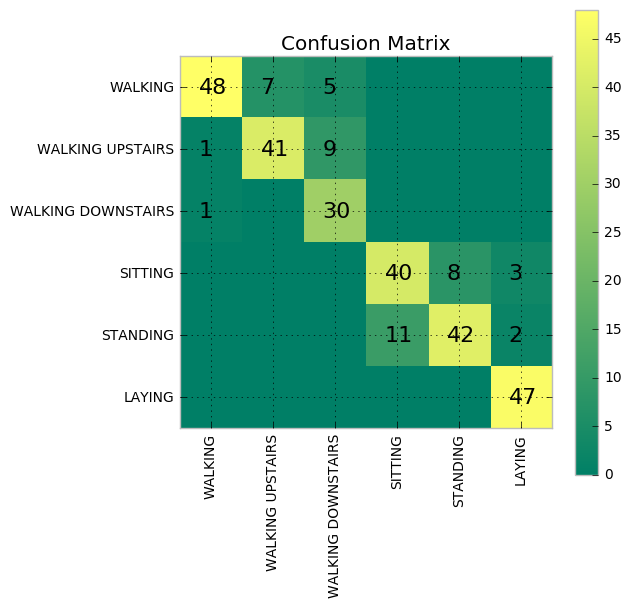

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print classification_report(label, y_test[::10],
                            target_names=[l for l in labels.values()])

conf_mat = confusion_matrix(label, y_test[::10])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.values()])

The KNN & DTW classifier performed very well across each of the 6 classes. It even beats the best classification rate published by the authors of the HAR paper.

However, this performance comes at a cost. The KNN algorithm is implemented using brute force. So, comparing 500 training observations to 500 test observations results in 250,000 DTW distances to be computed. And each (unconstrained) DTW distance calculation takes over 65K calculations each (256 x 256). This results in 16.3 billion calculations for just 500 x 500 observations.. Clearly not a scalable classification technique!

Performance improvements can be achieved by reducing the `max_warping_window` parameter. However, these gains will not be sufficient to make KNN & DTW a viable classification technique for large or medium sized datasets.

[****************100%******************]  400 of 400 complete


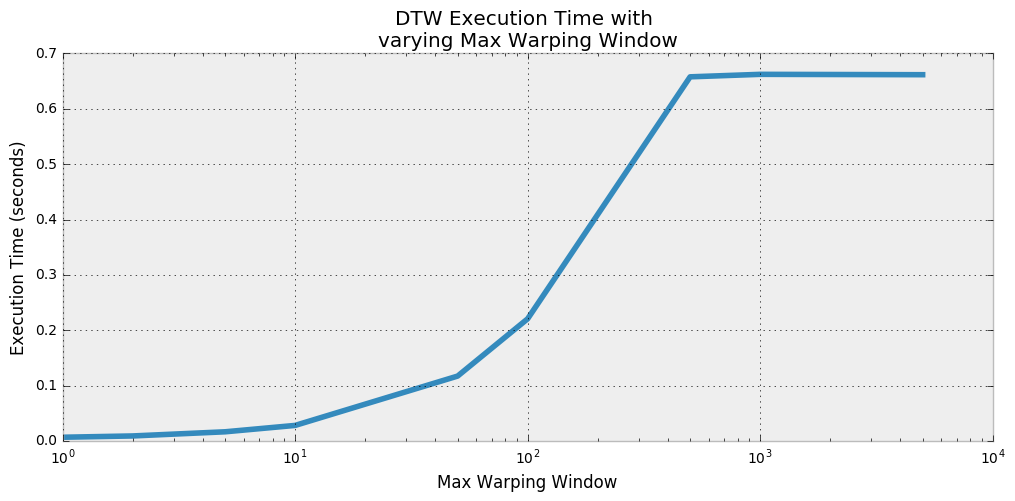

In [14]:
import time

time_taken = []
windows = [1,2,5,10,50,100,500,1000,5000]

for w in windows:
    begin = time.time()
    
    t = KnnDtw(n_neighbors=1, max_warping_window=w)
    t.fit(x_train[:20], y_train[:20])
    label, proba = t.predict(x_test[:20])
    
    end = time.time()
    time_taken.append(end - begin)

fig = plt.figure(figsize=(12,5))
_ = plt.plot(windows, [t/400. for t in time_taken], lw=4)
plt.title('DTW Execution Time with \nvarying Max Warping Window')
plt.ylabel('Execution Time (seconds)')
plt.xlabel('Max Warping Window')
plt.xscale('log')

---

#### Final thoughts
There are many improvements that could be made to this python implementation of KNN & DTW (eg. rewrite in C++ or explore parallel processing). However, the objective of this project was learning related. I've gained a deeper insight into the underlying mechanics of DTW by implementing it in python using dynamic programming techniques.

#### References
1.  Mitsa (2010). Temporal Data Mining (Chapter on Temporal Classification).
2.  Xi (2006). Fast Time Series Classification Using Numerosity Reduction.
3.  Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. Human Activity Recognition on Smartphones using a Multiclass Hardware-Friendly Support Vector Machine. International Workshop of Ambient Assisted Living (IWAAL 2012). Vitoria-Gasteiz, Spain. Dec 2012. [Read Paper](http://arxiv.org/pdf/1401.8212.pdf)

#### Credit
-  The progressbar used in the `DtwKnn()` class was taken from PYMC
-  The matplotlib style and IPython notebook was taken from Cameron Davidson-Pilon's excelent ["Bayesian Methods for Hackers"](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

In [15]:
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()